# Práctica 9: Promedio Temporal

En esta práctica se explora el concepto de promedio temporal aplicado al análisis estadístico de señales experimentales. Se generarán señales sintéticas, se aplicarán diferentes técnicas de promediado y se analizará la reducción de ruido y la convergencia estadística. Todos los datos y gráficos generados serán almacenados en la carpeta `data` en formatos CSV, PNG y SVG.

## 1. Importar Bibliotecas Necesarias

Importaremos las bibliotecas requeridas para el análisis numérico, visualización y manejo de archivos.

In [1]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from scipy import signal

# Configuración de estilo para gráficos
sns.set(style="whitegrid")
%matplotlib inline

## 2. Configurar Directorios y Parámetros

Se crearán las carpetas necesarias para almacenar los archivos generados y se definirán los parámetros del experimento.

In [2]:
# Definir rutas para guardar datos y gráficos
base_data_dir = Path("../data/P09")
csv_dir = base_data_dir / "csv"
fig_dir = base_data_dir / "figs"

for d in [csv_dir, fig_dir]:
    d.mkdir(parents=True, exist_ok=True)

# Parámetros del experimento
fs = 1000  # Frecuencia de muestreo (Hz)
duration = 2.0  # Duración de la señal (s)
t = np.arange(0, duration, 1/fs)
N = len(t)
num_realizaciones = 5  # Número de conjuntos de datos
noise_levels = [0.2, 0.5, 1.0]  # Niveles de ruido estándar

## 3. Generar Señales de Prueba

Se generarán señales sintéticas con componentes determinísticas y ruido aleatorio. Se crearán varias realizaciones para cada nivel de ruido.

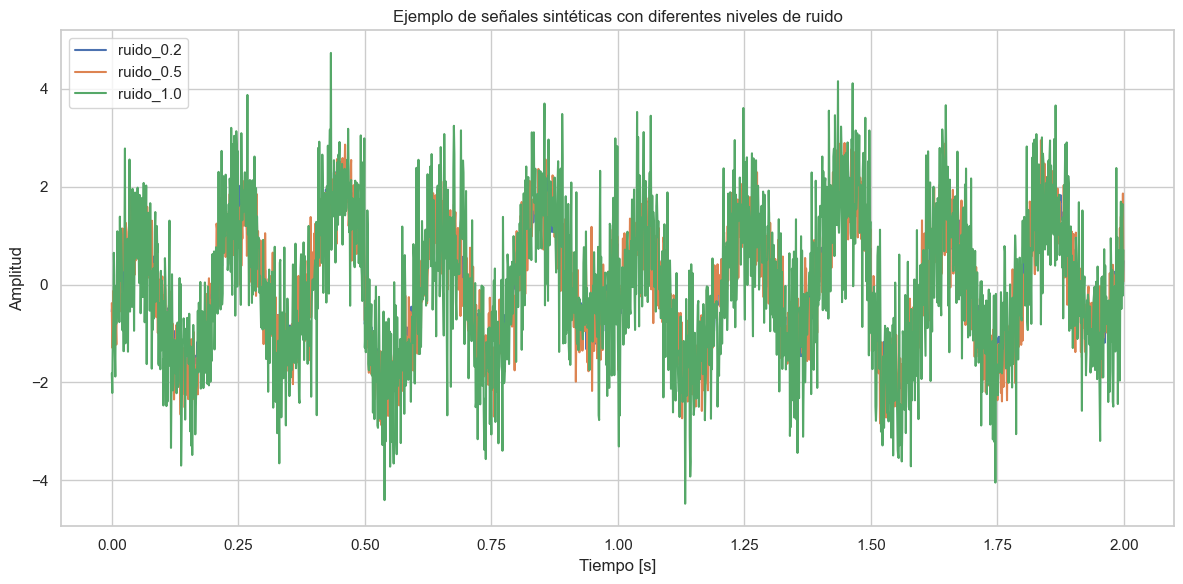

In [3]:
# Generar señales sintéticas
signals = {}
for idx, noise_std in enumerate(noise_levels):
    realizaciones = []
    for r in range(num_realizaciones):
        # Señal base: suma de seno y triangular
        base = 1.5 * np.sin(2 * np.pi * 5 * t) + 0.7 * signal.sawtooth(2 * np.pi * 2 * t)
        noise = np.random.normal(0, noise_std, size=N)
        s = base + noise
        realizaciones.append(s)
    signals[f"ruido_{noise_std}"] = np.array(realizaciones)

# Guardar señales originales en CSV
for key, arr in signals.items():
    df = pd.DataFrame(arr.T, columns=[f"real_{i+1}" for i in range(num_realizaciones)])
    df["t"] = t
    df.to_csv(csv_dir / f"senales_{key}.csv", index=False)

# Graficar una realización de cada nivel de ruido
plt.figure(figsize=(12,6))
for idx, (key, arr) in enumerate(signals.items()):
    plt.plot(t, arr[0], label=f"{key}")
plt.title("Ejemplo de señales sintéticas con diferentes niveles de ruido")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "senales_ruido.png")
plt.savefig(fig_dir / "senales_ruido.svg")
plt.show()

## 4. Implementar Promedio Temporal

Se implementarán funciones para calcular el promedio simple, promedio móvil y promedio ponderado sobre las señales generadas.

In [4]:
# Funciones de promediado temporal
def promedio_simple(arr):
    return np.mean(arr, axis=0)

def promedio_movil(arr, window=10):
    return np.convolve(arr, np.ones(window)/window, mode='same')

def promedio_ponderado(arr, pesos=None):
    if pesos is None:
        pesos = np.linspace(1, 2, arr.shape[0])
    pesos = pesos / np.sum(pesos)
    return np.average(arr, axis=0, weights=pesos)

# Ejemplo de aplicación sobre una señal
resultados_promedios = {}
for key, arr in signals.items():
    # Promedio simple entre realizaciones
    prom_simple = promedio_simple(arr)
    # Promedio móvil sobre la primera realización
    prom_movil = promedio_movil(arr[0], window=50)
    # Promedio ponderado entre realizaciones
    prom_pond = promedio_ponderado(arr)
    resultados_promedios[key] = {
        'simple': prom_simple,
        'movil': prom_movil,
        'ponderado': prom_pond
    }

# Guardar resultados de promedios
for key, res in resultados_promedios.items():
    df = pd.DataFrame({
        't': t,
        'simple': res['simple'],
        'movil': res['movil'],
        'ponderado': res['ponderado']
    })
    df.to_csv(csv_dir / f"promedios_{key}.csv", index=False)

## 5. Análisis Estadístico de Señales

Se calcularán estadísticas descriptivas y se analizará la evolución del promedio y la reducción de ruido conforme aumenta el número de promedios.

In [5]:
# Análisis estadístico y evolución del promedio
def calcular_snr(signal, noise):
    power_signal = np.mean(signal**2)
    power_noise = np.mean(noise**2)
    return 10 * np.log10(power_signal / power_noise)

estadisticas = {}
for key, arr in signals.items():
    base = 1.5 * np.sin(2 * np.pi * 5 * t) + 0.7 * signal.sawtooth(2 * np.pi * 2 * t)
    medias = [np.mean(a) for a in arr]
    stds = [np.std(a) for a in arr]
    snrs = [calcular_snr(base, a-base) for a in arr]
    # Promedio iterativo
    proms_iter = [np.mean(arr[:i+1], axis=0) for i in range(num_realizaciones)]
    stds_proms = [np.std(p-base) for p in proms_iter]
    snrs_proms = [calcular_snr(base, p-base) for p in proms_iter]
    estadisticas[key] = {
        'media': medias,
        'std': stds,
        'snr': snrs,
        'std_proms': stds_proms,
        'snr_proms': snrs_proms
    }

# Guardar estadísticas
for key, est in estadisticas.items():
    df = pd.DataFrame({
        'media': est['media'],
        'std': est['std'],
        'snr': est['snr'],
        'std_proms': est['std_proms'],
        'snr_proms': est['snr_proms']
    })
    df.to_csv(csv_dir / f"estadisticas_{key}.csv", index=False)

## 6. Comparación de Métodos de Promediado

Se compararán los métodos de promedio simple, móvil y ponderado en términos de reducción de ruido y preservación de la señal.

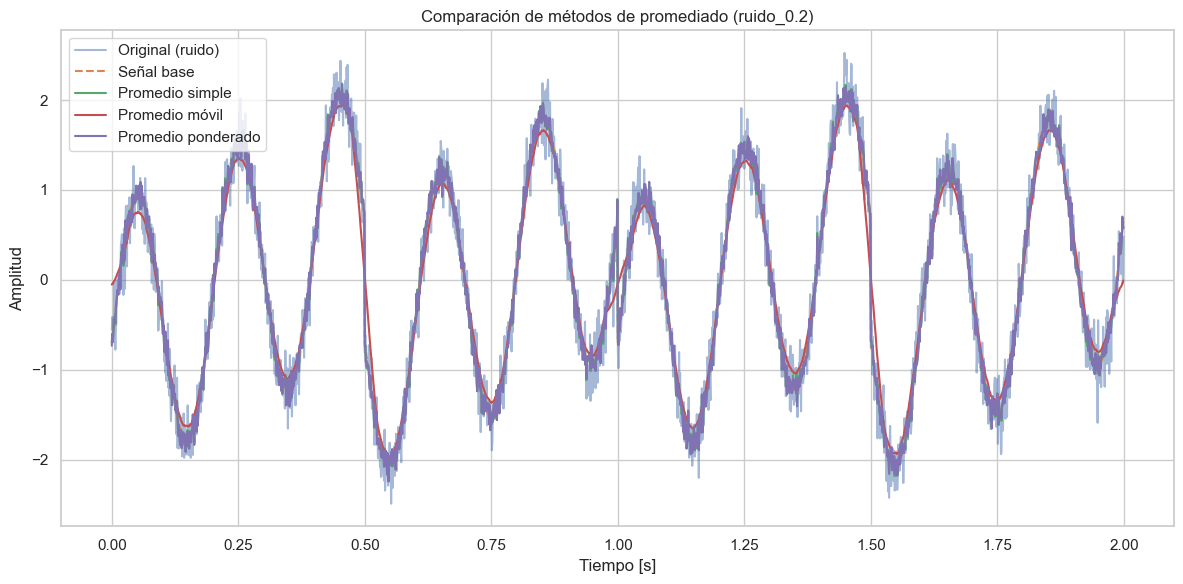

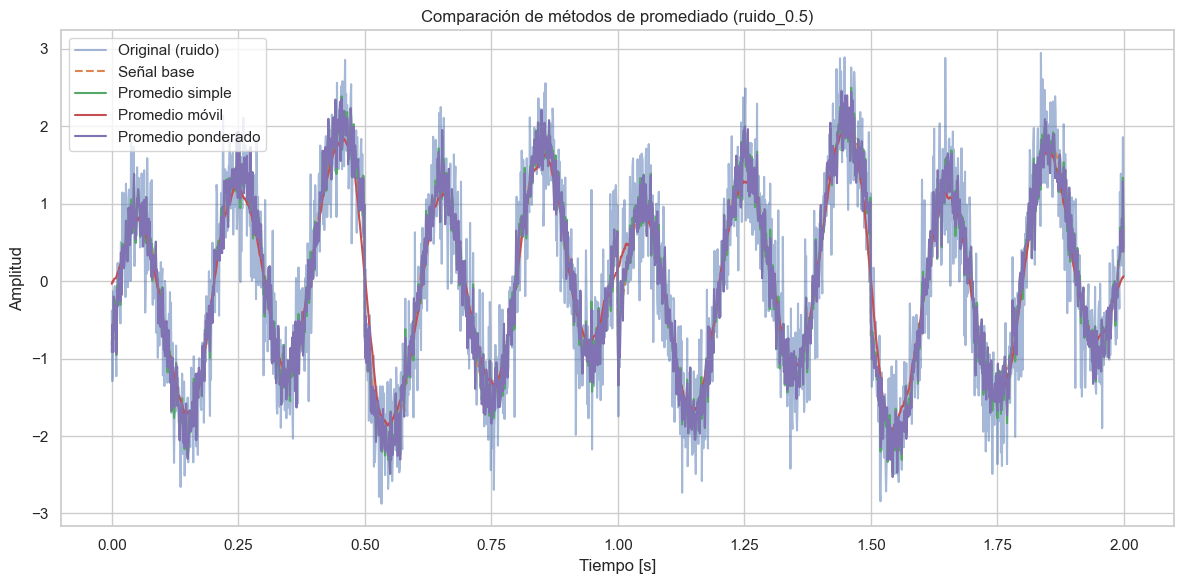

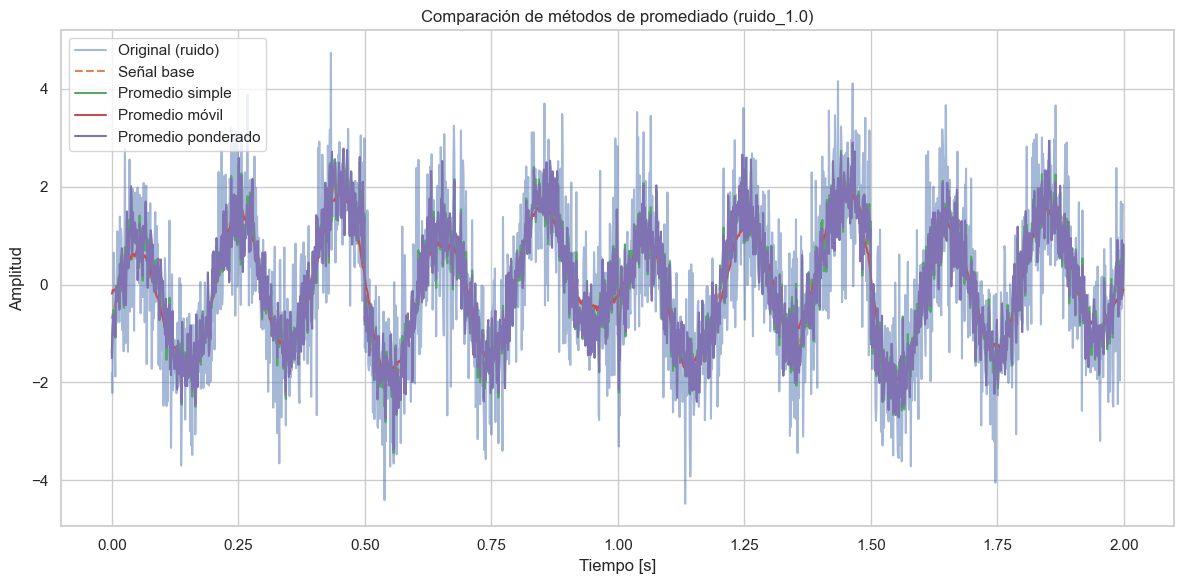

In [6]:
# Comparación visual de métodos de promediado
for key, arr in signals.items():
    base = 1.5 * np.sin(2 * np.pi * 5 * t) + 0.7 * signal.sawtooth(2 * np.pi * 2 * t)
    res = resultados_promedios[key]
    plt.figure(figsize=(12,6))
    plt.plot(t, arr[0], label="Original (ruido)", alpha=0.5)
    plt.plot(t, base, label="Señal base", linestyle='--')
    plt.plot(t, res['simple'], label="Promedio simple")
    plt.plot(t, res['movil'], label="Promedio móvil")
    plt.plot(t, res['ponderado'], label="Promedio ponderado")
    plt.title(f"Comparación de métodos de promediado ({key})")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()
    plt.savefig(fig_dir / f"comparacion_promedios_{key}.png")
    plt.savefig(fig_dir / f"comparacion_promedios_{key}.svg")
    plt.show()

## 7. Visualización de Resultados

Se mostrarán gráficos de la evolución del SNR y la desviación estándar en función del número de promedios, así como distribuciones estadísticas.

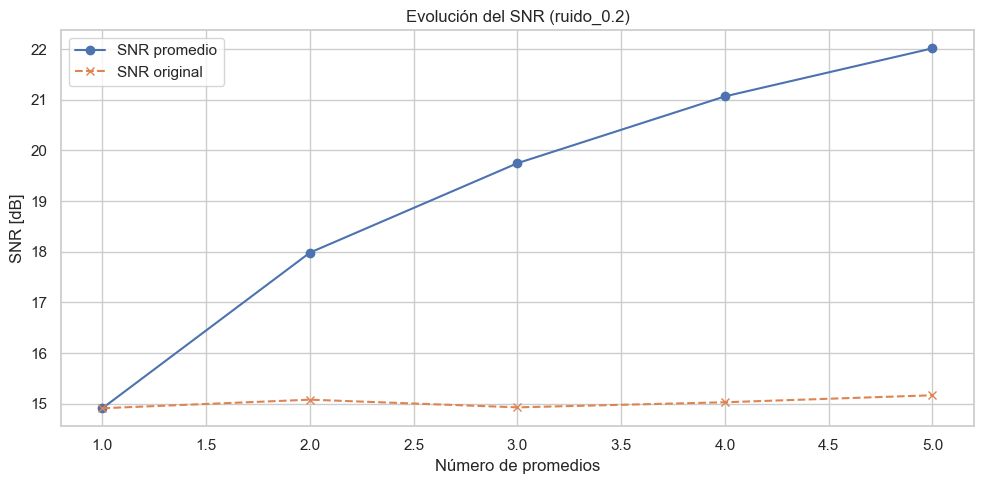

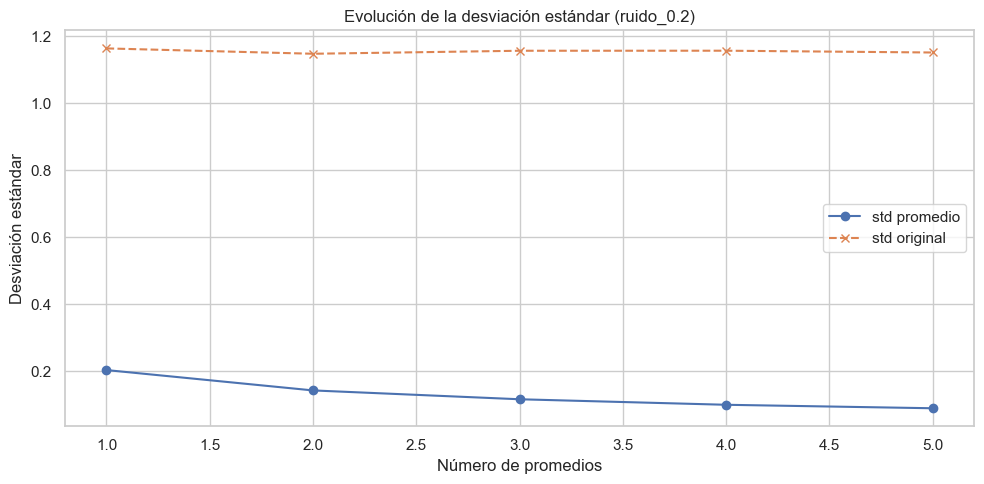

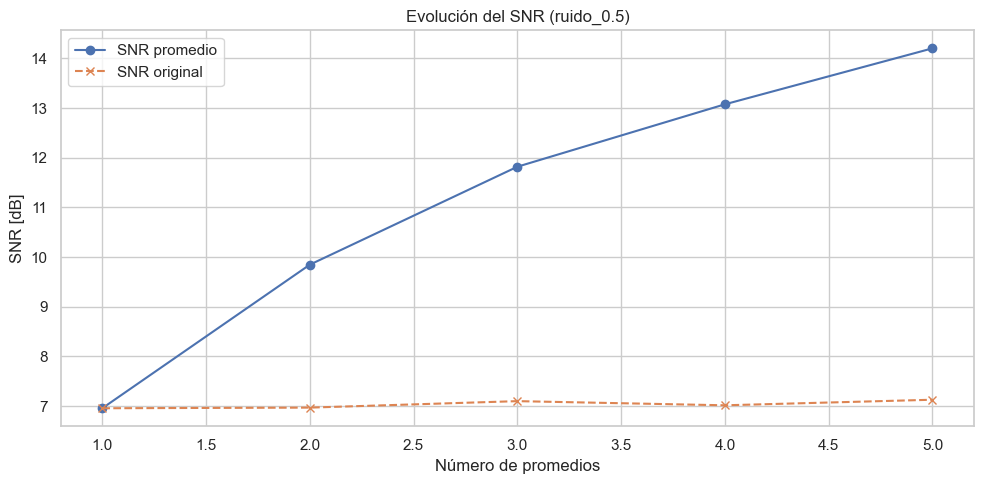

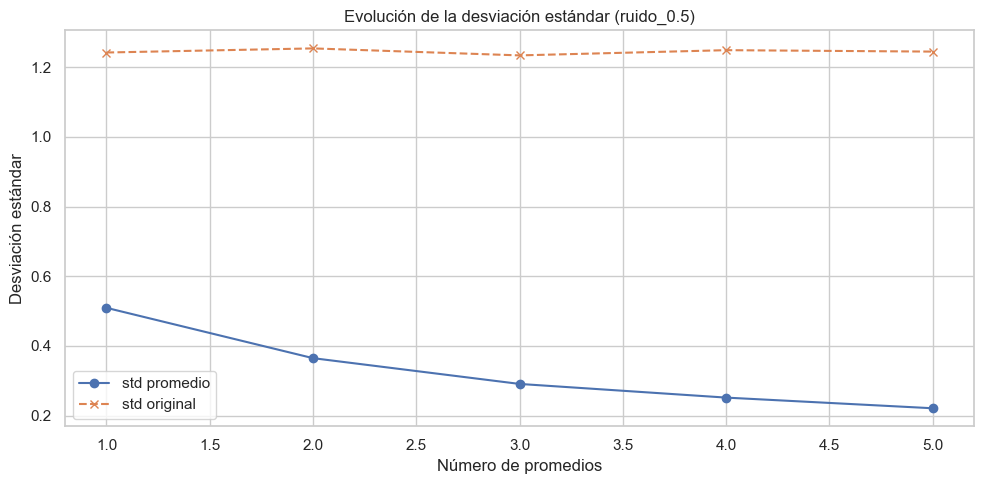

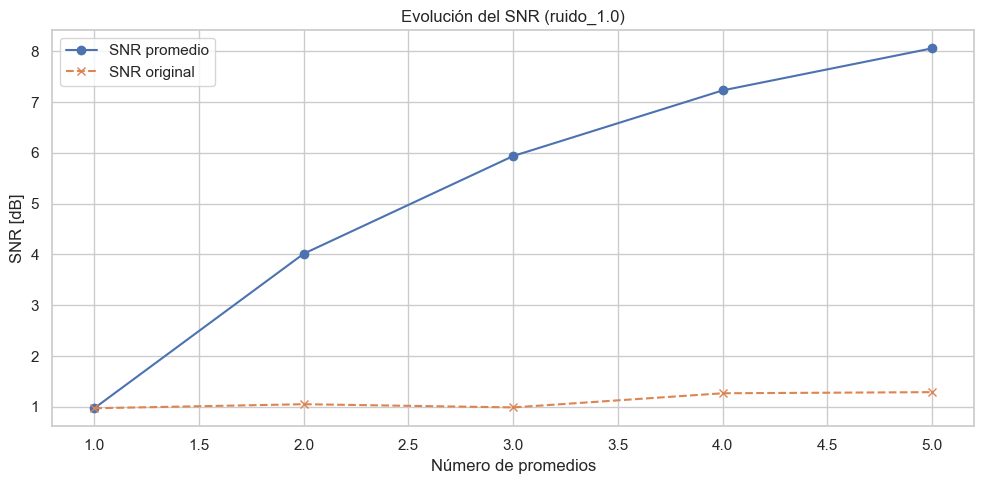

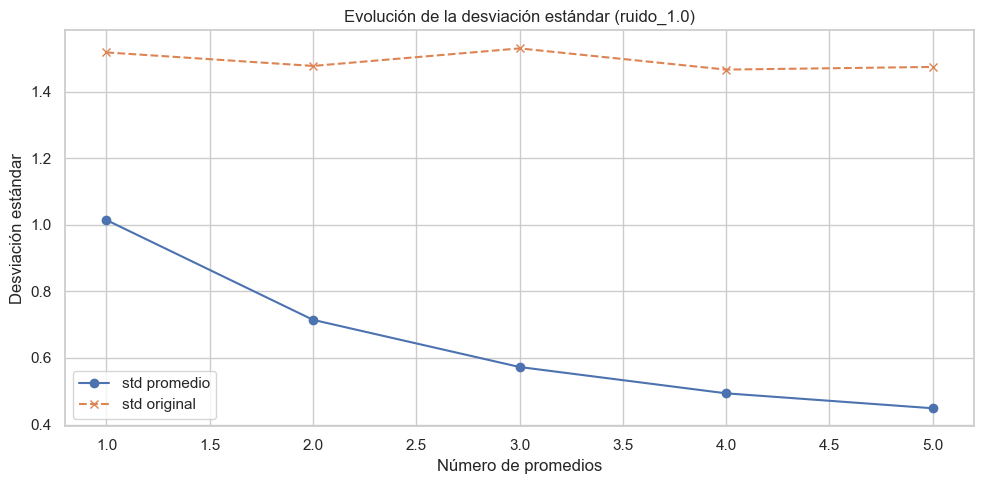

In [7]:
# Visualización de evolución de SNR y std
for key, est in estadisticas.items():
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_realizaciones+1), est['snr_proms'], marker='o', label='SNR promedio')
    plt.plot(range(1, num_realizaciones+1), est['snr'], marker='x', label='SNR original', linestyle='--')
    plt.xlabel('Número de promedios')
    plt.ylabel('SNR [dB]')
    plt.title(f'Evolución del SNR ({key})')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fig_dir / f"evolucion_snr_{key}.png")
    plt.savefig(fig_dir / f"evolucion_snr_{key}.svg")
    plt.show()
    # Desviación estándar
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_realizaciones+1), est['std_proms'], marker='o', label='std promedio')
    plt.plot(range(1, num_realizaciones+1), est['std'], marker='x', label='std original', linestyle='--')
    plt.xlabel('Número de promedios')
    plt.ylabel('Desviación estándar')
    plt.title(f'Evolución de la desviación estándar ({key})')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fig_dir / f"evolucion_std_{key}.png")
    plt.savefig(fig_dir / f"evolucion_std_{key}.svg")
    plt.show()

## 8. Guardar Datos y Gráficos

Todos los datos y gráficos generados han sido almacenados en la carpeta `data/P09` en formatos CSV, PNG y SVG. A continuación, se muestra un resumen de los parámetros utilizados y las métricas obtenidas.

In [8]:
# Resumen de parámetros y métricas
print(f"Frecuencia de muestreo: {fs} Hz")
print(f"Duración de la señal: {duration} s")
print(f"Número de muestras: {N}")
print(f"Niveles de ruido: {noise_levels}")
print(f"Número de realizaciones: {num_realizaciones}")

for key, est in estadisticas.items():
    print(f"\n--- Estadísticas para {key} ---")
    print(f"Media original: {np.mean(est['media']):.3f}")
    print(f"Desviación estándar original: {np.mean(est['std']):.3f}")
    print(f"SNR original promedio: {np.mean(est['snr']):.2f} dB")
    print(f"SNR tras promediado: {est['snr_proms'][-1]:.2f} dB")

Frecuencia de muestreo: 1000 Hz
Duración de la señal: 2.0 s
Número de muestras: 2000
Niveles de ruido: [0.2, 0.5, 1.0]
Número de realizaciones: 5

--- Estadísticas para ruido_0.2 ---
Media original: -0.004
Desviación estándar original: 1.155
SNR original promedio: 15.02 dB
SNR tras promediado: 22.01 dB

--- Estadísticas para ruido_0.5 ---
Media original: -0.006
Desviación estándar original: 1.244
SNR original promedio: 7.03 dB
SNR tras promediado: 14.20 dB

--- Estadísticas para ruido_1.0 ---
Media original: -0.008
Desviación estándar original: 1.493
SNR original promedio: 1.12 dB
SNR tras promediado: 8.06 dB
